In [21]:
import os
import io
import numpy as np
from keras.preprocessing import image
import pandas as pd
from PIL import Image, ImageChops, ImageEnhance
import os
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Model, Sequential 
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping




In [22]:
def jpeg_compression(img: Image.Image, quality: int=90) -> Image.Image:
    if img.mode != 'RGB':
        img = img.convert('RGB')
    buffer = io.BytesIO()
    img.save(buffer, format='JPEG', quality=quality)
    im_data = buffer.getvalue()
    img = Image.open(io.BytesIO(im_data))
    buffer.close()
    return img


In [23]:
def convert_to_ela(img):
    im = img.convert('RGB')
    resaved_im = jpeg_compression(im)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

In [24]:
#Defining Parameters
data_path = "../casia/casia_ela/"
batch_size = 64
nb_epochs = 30
img_width = 256
img_height = 256


In [25]:
model = Sequential()

# input dimensions 

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid',activation ='relu', input_shape=(img_height, img_width, 3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)
 

model.add(MaxPooling2D(pool_size = (2, 2)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)



model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPooling2D(pool_size=(2,2)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape, "  <----------")



#def tf_spatial_pyramid_pooling(tf_input_feature_maps, tf_spatial_pyramid, dtype=tf.float32):
#    return tf.py_func(np_spatial_pyramid_pooling, [tf_input_feature_maps, tf_spatial_pyramid], dtype)
#average pooling !!

#from keras.layers import Input
#from keras.models import Model
#from keras_pyramid_pooling_module import PyramidPoolingModule

#input_ = Input((224, 224, 3))
#x = PyramidPoolingModule()(input_)
#model = Model(inputs=input_, outputs=x)








#model.add(GlobalAveragePooling2D())
#print("Input: ", model.input_shape)
#print("Output: ", model.output_shape, " <-----------")


model.add(Flatten())
print("Input: ", model.input_shape)
print("Output: ", model.output_shape, "final2")

model.add(Dense(256, activation = "relu"))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)
    

model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape, "final2")



Input:  (None, 256, 256, 3)
Output:  (None, 252, 252, 32)
Input:  (None, 256, 256, 3)
Output:  (None, 126, 126, 32)
Input:  (None, 256, 256, 3)
Output:  (None, 122, 122, 32)
Input:  (None, 256, 256, 3)
Output:  (None, 61, 61, 32)
Input:  (None, 256, 256, 3)
Output:  (None, 61, 61, 32)   <----------
Input:  (None, 256, 256, 3)
Output:  (None, 119072) final2
Input:  (None, 256, 256, 3)
Output:  (None, 256)
Input:  (None, 256, 256, 3)
Output:  (None, 2) final2


In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 122, 122, 32)      25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 119072)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

In [27]:
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)

In [28]:
model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [29]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [30]:
weights = "test6.hdf5"
model.load_weights(weights)


In [31]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [32]:
train_data = train_datagen.flow_from_directory(
    data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

Found 11469 images belonging to 2 classes.


In [33]:
validation_data = train_datagen.flow_from_directory(
    data_path, # same directory as training data
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 2866 images belonging to 2 classes.


In [34]:
history = model.fit_generator(
            train_data,
            steps_per_epoch = train_data.samples // batch_size,
            validation_data = validation_data, 
            validation_steps = validation_data.samples // batch_size,
            epochs = nb_epochs,
            callbacks = [early_stopping])

Epoch 1/30
179/179 [==============================] - 1259s 7s/step - loss: 0.5178 - accuracy: 0.7725 - val_loss: 0.7859 - val_accuracy: 0.6424
Epoch 2/30
179/179 [==============================] - 843s 5s/step - loss: 0.3272 - accuracy: 0.8583 - val_loss: 0.9828 - val_accuracy: 0.6674
Epoch 3/30
179/179 [==============================] - 817s 5s/step - loss: 0.2920 - accuracy: 0.8735 - val_loss: 1.4438 - val_accuracy: 0.6727
Epoch 4/30
179/179 [==============================] - 822s 5s/step - loss: 0.2673 - accuracy: 0.8849 - val_loss: 0.7326 - val_accuracy: 0.6824
Epoch 5/30
179/179 [==============================] - 822s 5s/step - loss: 0.2621 - accuracy: 0.8897 - val_loss: 1.0503 - val_accuracy: 0.6756
Epoch 6/30
179/179 [==============================] - 824s 5s/step - loss: 0.2419 - accuracy: 0.8992 - val_loss: 1.1585 - val_accuracy: 0.6817


In [35]:
print("done")

done


In [36]:
#w_test6 = "saved_weights/test6.hdf5"
#model.save_weights(w_test6, overwrite = True)

In [37]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


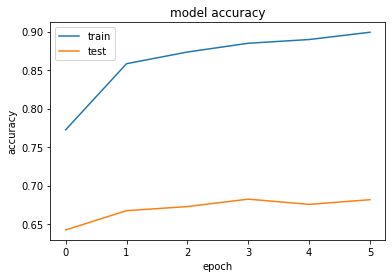

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



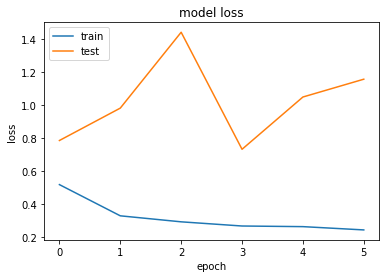

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(validation_data, validation_data.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_data.classes, y_pred))


print('Classification Report')
target_names = ['Aut', 'Tamp']
print(classification_report(validation_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1214  444]
 [ 863  345]]
Classification Report
              precision    recall  f1-score   support

         Aut       0.58      0.73      0.65      1658
        Tamp       0.44      0.29      0.35      1208

    accuracy                           0.54      2866
   macro avg       0.51      0.51      0.50      2866
weighted avg       0.52      0.54      0.52      2866



In [41]:
x, y = validation_data.class_indices
print(x, y)

aut tamp


In [ ]:
#path of any test image
predict_path = "predict_images/i1_cm1.jpg"



In [ ]:
from IPython.display import Image as imgloader
display(imgloader(filename = predict_path, width = img_width, height=img_height))


In [ ]:
test_img = image.load_img(predict_path, target_size = (img_width, img_height))


test_img = convert_to_ela(test_img)



temp = test_img
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
temp


In [ ]:
train_data.class_indices

In [ ]:
result

In [ ]:
tamp = result[0][1]
if(tamp==1):
    print("Fake image, some tampering detected !")
else:
    print("The image looks authentic !")